# <B> CS517 Project </B>
## GVF Snakes (Active contours)

### 1. Package Imports

In [50]:
import matplotlib.pyplot as plt
import cv2
from tqdm import notebook
from tqdm.notebook import tqdm as tqdm
import skimage.filters as skimage_filter
import numpy as np

### 2. File input


Enter image path: 

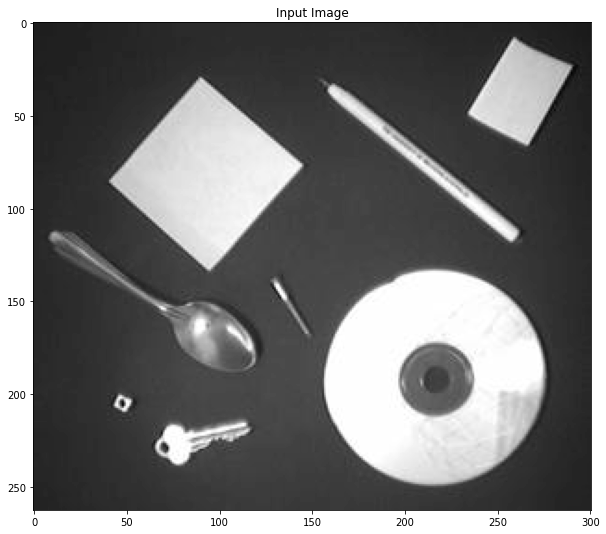

In [51]:
print("Enter image path: ", end = "")
imgPath = "../test_images/4.jpg"
# taking image as input, converting into grayscale
img = None
try:
    img = cv2.imread(imgPath, 0)
except:
    # in case file is not found
    print("Image path incorrect.")
    exit(0)

# img = img.astype(np.float32)
# img = img/255
# img2 = img.copy()
# img2 = img2.astype(np.float32) 
# img2 = img / 255 # rescaling the pixel values

plt.figure(figsize=(10, 10))
plt.subplot(1, 1, 1)
plt.title("Input Image")
plt.imshow(img, cmap="gray")

### 3. Edge Map

To get the GVF field, the first step is to extract 
the edge map function $f(x, y)$ from the image $I(x, y)$. 

According to the paper ```Snakes, shapes, and gradient vector flow``` by Xu & Prince,
the edge map should follow given properties:
* The gradient of an edge map has vectors normal to the edges
* Large values of intensity near the edges.
* Places where $I(x, y)$ is constant, $\nabla f(x, y)$ is 0

A suitable edge map function, which has been considered is:

$f(x, y) = −|\nabla[G_{σ}(x , y)∗I(x , y)]|$

where $G_{σ}$(x , y) is a two dimension gaussian function with standard deviation $σ$.

* Gaussian filter has been used to remove noise from the image.
* Further, sobel filter has been applied for calculating gradient on the resultant image.


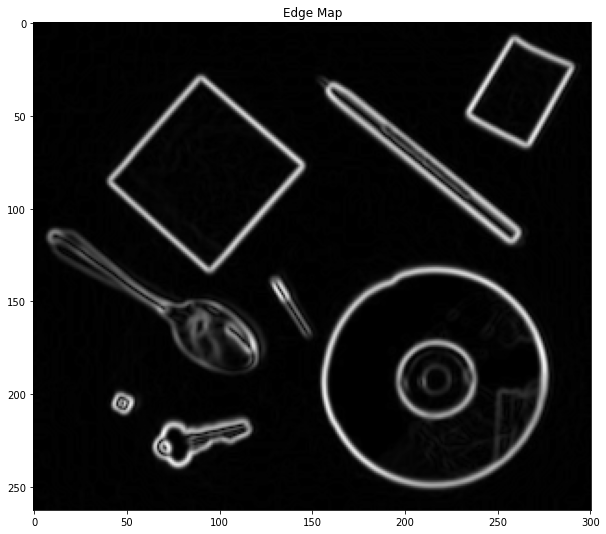

In [52]:
blurImg = cv2.GaussianBlur(img, (5, 5), 0)
gradX = cv2.Sobel(blurImg, cv2.CV_64F, 1, 0) # taking gradient in X direction
gradY = cv2.Sobel(blurImg, cv2.CV_64F, 0, 1) # taking gradient in Y direction
# calculating sqrt((gradX)**2 + (gradY)**2)
edgeMap = np.sqrt((gradX**2) + (gradY**2))
edgeMap = skimage_filter.sobel(blurImg)

plt.figure(figsize=(10, 10))
plt.subplot(1, 1, 1)
plt.title("Edge Map")
plt.imshow(edgeMap, cmap="gray")

### 4. Gradient field
Calculation of the gradient vectors of the edge map image

For horizontal direction:
fx(i, j) = (f(i, j+1) - f(i, j-1))/2
for corner case:
* fx(i, 0) = f(i, 1) - f(i, 0)
* fx(i, len-1) = f(i, len-1) - f(i, len-2)
Similarly for gradient in vertical direction


In [53]:
tempIm = edgeMap.copy()
tempIm = cv2.GaussianBlur(tempIm, (5, 5), 0)


gradientX = tempIm.copy()
gradientY = tempIm.copy()
for i in range(tempIm.shape[0]):
    for j in range(tempIm.shape[1]):
        if(j == 0):
            gradientX[i][j] = tempIm[i][j+1] - tempIm[i][j]
        elif(j == tempIm.shape[1]-1):
            gradientX[i][j] = tempIm[i][j] - tempIm[i][j-1]
        else:
            gradientX[i][j] = (tempIm[i][j+1] - tempIm[i][j-1])/2


for i in range(tempIm.shape[1]):
    for j in range(tempIm.shape[0]):
        if(j == 0):
            gradientY[j][i] = tempIm[j+1][i] - tempIm[j][i]
        elif(j == tempIm.shape[0]-1):
            gradientY[j][i] = tempIm[j][i] - tempIm[j-1][i]
        else:
            gradientY[j][i] = (tempIm[j+1][i] - tempIm[j-1][i])/2

# def vmin(values): 
#     return -max(values.max(), -values.min())
# def vmax(values): 
#     return max(values.max(), -values.min())
# fig, axs = plt.subplots(2, 4, figsize=(16, 8))
fig.suptitle('Gradient Vector Flow (2D) demo')
ax = axs[0][2]; ax.imshow(gradientX, vmin=vmin(gradientX), vmax=vmax(gradientX), cmap='seismic'); ax.set_title('gradientX')
ax = axs[0][3]; ax.imshow(gradientY, vmin=vmin(gradientX), vmax=vmax(gradientX), cmap='seismic'); ax.set_title('gradientY')

### 5. Gradient Vector field

According to the paper, the iterative solution to the GVF, after few approximations can be written as:

$u_{i, j}^{n+1} = (1-b_{i, j}\Delta t)u_{i, j}^{n} + r(u_{i+1, j}^{n} + u_{i, j+1}^{n} + u_{i-1, j}^{n} + u_{i, j-1}^{n} - 4u_{i, j}^{n}) +  c_{i, j}^{1}\Delta t$

$v_{i, j}^{n+1} = (1-b_{i, j}\Delta t)v_{i, j}^{n} + r(v_{i+1, j}^{n} + v_{i, j+1}^{n} + v_{i-1, j}^{n} + v_{i, j-1}^{n} - 4v_{i, j}^{n}) +  c_{i, j}^{2}\Delta t$

These equations can be rewritten as (in terms of 2D matrix algebra(numpy)):

$u^{n+1} = (1-b*\Delta t)u^{n} + r*laplacian_{3x3}(u^{n}) + c_{1}\Delta t$

$v^{n+1} = (1-b*\Delta t)v^{n} + r*laplacian_{3x3}(v^{n}) + c_{2}\Delta t$

where, 

$r = μ\Delta t /\Delta x\Delta y$, the Courant–Friedrichs–Lewy step-size restriction

$b(x, y) = f_{x}(x, y)^{2} + f_{y}(x, y)^{2}$

$c^{1}(x, y) = b(x, y)f_{x}(x, y)$
    
$c^{2}(x, y) = b(x, y)f_{y}(x, y)$

$μ$ is a parameter that depends on the noise level of the image. It should be in directly proptional nature with the image noise level. If the noise is high, the value of $μ$, should be increased.

The paper suggests that "Provided that $b$, $c^{1}$ and $c^{2}$ are bounded, the first two equations are stable whenever the value of $r <= 0.25$".

We will calculate \Delta t using:

$\Delta t = \Delta x\Delta y/rμ$, the Courant–Friedrichs–Lewy step-size restriction


Number of iterations have been taken to be $\sqrt N$, as per the suggestion of the paper itself, where N is the area of the image $(h*w)$.


In [54]:
# parameters for GVF
# as defined in the above markdown
dx, dy = 1.0, 1.0
mu = 1.0
r = 0.25
b = np.square(gradientX) + np.square(gradientY)
c1, c2 = b*gradientX, b*gradientY
dt = dx*dy/(r*mu)
N = img.shape[0]*img.shape[1]
iter = int(np.sqrt(N)) 
iterations = list(range(iter))

# initializing u, v with the values of fx and fy
u, v = gradientX, gradientY

for i in tqdm(iterations):
    lapU = cv2.Laplacian(u, -1, 3) # laplacian with kernel size 3
    lapV = cv2.Laplacian(v, -1, 3)
    u = (1.0 - b*dt)*u + r*lapU + c1*dt
    v = (1.0 - b*dt)*v + r*lapV + c2*dt

gx, gy = u, v

  0%|          | 0/281 [00:00<?, ?it/s]

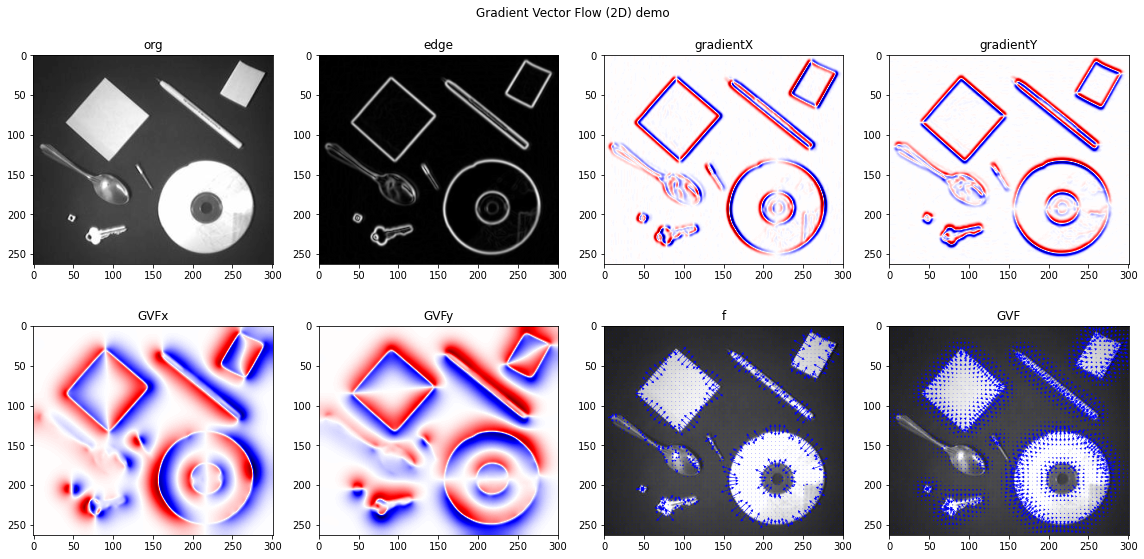

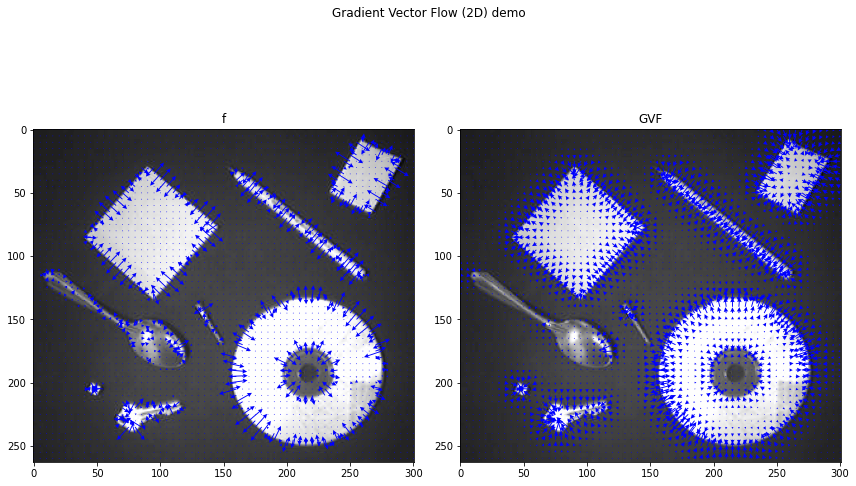

In [55]:
H, W = img.shape
Y, X = np.meshgrid(range(0, H, 5), range(0, W, 5))
def plot_vector_field(ax, vx, vy):
    scale = np.sqrt(np.max(vx**2+vy**2))*20.0
    ax.imshow(img, cmap='gray')
    # vy shold be inversed (top=+Y -> top=-Y)
    ax.quiver(X, Y, vx[Y, X], -vy[Y, X], scale=scale, color='blue', headwidth=5)

ax = axs[1][0]; ax.imshow(gx, vmin=vmin(gx), vmax=vmax(gx), cmap='seismic'); ax.set_title('GVFx')
ax = axs[1][1]; ax.imshow(gy, vmin=vmin(gy), vmax=vmax(gy), cmap='seismic'); ax.set_title('GVFy')
ax = axs[1][2]; plot_vector_field(ax, gradientX, gradientY); ax.set_title('f')
ax = axs[1][3]; plot_vector_field(ax, gx, gy); ax.set_title('GVF')
fig.tight_layout()
fig, axs = plt.subplots(1, 2, figsize=(12, 8))
fig.suptitle('Gradient Vector Flow (2D) demo')
ax = axs[0]; plot_vector_field(ax, gradientX, gradientY); ax.set_title('f')
ax = axs[1]; plot_vector_field(ax, gx, gy); ax.set_title('GVF')
fig.tight_layout()
plt.show()

## References
* <h3> http://www.iacl.ece.jhu.edu/pubs/p084j.pdf </h3>
* <h3> https://homepages.inf.ed.ac.uk/rbf/CVonline/LOCAL_COPIES/AV1011/cartas.pdf</h3>
* <h2>

In [56]:


"""
numpy.hstack() function is used to stack the sequence of input arrays horizontally 
(i.e. column wise) to make a single array.

numpy.vstack() function is used to stack the sequence of input arrays vertically 
(i.e. row wise) to make a single array.

"""


# def laplacian(m):
#     return np.hstack([m[:, 0:1], m[:, :-1]]) + np.hstack([m[:, 1:], m[:, -2:-1]]) \
#             + np.vstack([m[0:1, :], m[:-1, :]]) + np.vstack([m[1:, :], m[-2:-1, :]]) \
#             - 4*m

# gradientX = np.hstack([tempIm[:, 1:], tempIm[:, -2:-1]]) - tempIm 
# gradientX = np.hstack([tempIm[:, 1:], tempIm[:, -2:-1]]) - np.hstack([tempIm[:, 0:1], tempIm[:, :-1]]) 
# gradientY = np.vstack([tempIm[1:, :], tempIm[-2:-1, :]]) - np.vstack([tempIm[0:1, :], tempIm[:-1, :]]) 
# print(gradientXshsape, gradX.shape, gradientX == gradX)

'\nnumpy.hstack() function is used to stack the sequence of input arrays horizontally \n(i.e. column wise) to make a single array.\n\nnumpy.vstack() function is used to stack the sequence of input arrays vertically \n(i.e. row wise) to make a single array.\n\n'